# 10. Class Weight 消融實驗

## 目的
驗證 class_weight（類別權重）對不平衡資料集預測效能的影響。

## 實驗設計
比較以下類別權重設定：
1. **None**：無權重（原始分佈）
2. **balanced**：自動計算平衡權重
3. **custom**：自訂權重（如 1:3, 1:5, 1:10）

## 評估指標
- AUC：整體判別能力
- Sensitivity（Recall）：找出患病者的能力
- Specificity：正確排除健康者的能力
- F1-Score：精確率與召回率的調和平均
- Balanced Accuracy：平衡準確率

In [ ]:
# 載入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score,
    balanced_accuracy_score, confusion_matrix
)
import xgboost as xgb

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 套件載入完成")

In [12]:
# 載入資料
df = pd.read_csv('../../data/processed/SUA_CVDs_wide_format.csv')
print(f"✅ 資料載入成功！")
print(f"資料形狀: {df.shape[0]:,} 人, {df.shape[1]} 個欄位")

✅ 資料載入成功！
資料形狀: 6,056 人, 107 個欄位


In [13]:
# 定義特徵和目標變數
feature_cols = [
    'sex', 'Age',
    'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1',
    'FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2',
    'Delta1_FBG', 'Delta1_TC', 'Delta1_Cr', 'Delta1_UA', 'Delta1_GFR', 'Delta1_BMI', 'Delta1_SBP', 'Delta1_DBP'
]

target_cols = {
    '高血壓': 'hypertension_T3',
    '高血糖': 'hyperglycemia_T3',
    '高血脂': 'dyslipidemia_T3'
}

X = df[feature_cols].copy()

# 轉換目標變數：原始值 1=正常, 2=患病 → 轉換為 0=正常, 1=患病
targets = {}
for name, col in target_cols.items():
    targets[name] = (df[col] == 2).astype(int)

print("="*60)
print("類別不平衡情況")
print("="*60)
for name, y in targets.items():
    pos_rate = y.mean() * 100
    neg_count = (y == 0).sum()
    pos_count = (y == 1).sum()
    ratio = neg_count / pos_count
    print(f"{name}: {pos_rate:.2f}% 患病率 (負:正 = {ratio:.1f}:1)")

類別不平衡情況
高血壓: 16.68% 患病率 (負:正 = 5.0:1)
高血糖: 5.53% 患病率 (負:正 = 17.1:1)
高血脂: 5.96% 患病率 (負:正 = 15.8:1)


In [ ]:
def evaluate_with_class_weight(X, y, class_weight, model_type='LR', n_splits=5, random_state=42):
    """
    使用指定的 class_weight 評估模型
    
    model_type: 'LR', 'XGB', 'RF', 'SVM'
    
    Returns:
        dict: 包含各種評估指標
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # 儲存每個 fold 的結果
    auc_scores = []
    sensitivity_scores = []
    specificity_scores = []
    f1_scores = []
    bal_acc_scores = []
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # 標準化
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 建立模型
        if model_type == 'LR':
            model = LogisticRegression(
                class_weight=class_weight,
                max_iter=1000,
                random_state=random_state
            )
            model.fit(X_train_scaled, y_train)
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            y_pred = model.predict(X_test_scaled)
            
        elif model_type == 'XGB':
            if class_weight is None:
                scale_pos_weight = 1
            elif class_weight == 'balanced':
                scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
            else:  # custom weight dict {0: w0, 1: w1}
                scale_pos_weight = class_weight[1] / class_weight[0]
            
            model = xgb.XGBClassifier(
                scale_pos_weight=scale_pos_weight,
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                random_state=random_state,
                eval_metric='logloss',
                verbosity=0
            )
            model.fit(X_train_scaled, y_train)
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            y_pred = model.predict(X_test_scaled)
            
        elif model_type == 'RF':
            model = RandomForestClassifier(
                n_estimators=100,
                class_weight=class_weight,
                random_state=random_state,
                n_jobs=-1
            )
            model.fit(X_train_scaled, y_train)
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            y_pred = model.predict(X_test_scaled)
            
        elif model_type == 'SVM':
            model = SVC(
                kernel='rbf',
                class_weight=class_weight,
                probability=True,
                random_state=random_state
            )
            model.fit(X_train_scaled, y_train)
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            y_pred = model.predict(X_test_scaled)
        
        # 計算指標
        auc_scores.append(roc_auc_score(y_test, y_prob))
        
        # Confusion matrix for sensitivity and specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity_scores.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        specificity_scores.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        
        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        bal_acc_scores.append(balanced_accuracy_score(y_test, y_pred))
    
    return {
        'AUC': np.mean(auc_scores),
        'AUC_std': np.std(auc_scores),
        'Sensitivity': np.mean(sensitivity_scores),
        'Sensitivity_std': np.std(sensitivity_scores),
        'Specificity': np.mean(specificity_scores),
        'Specificity_std': np.std(specificity_scores),
        'F1': np.mean(f1_scores),
        'F1_std': np.std(f1_scores),
        'Balanced_Acc': np.mean(bal_acc_scores),
        'Balanced_Acc_std': np.std(bal_acc_scores)
    }

print("✅ 評估函數定義完成（支援 LR, XGB, RF, SVM）")

In [15]:
# 定義要測試的 class_weight 設定
weight_configs = {
    'None': None,
    'balanced': 'balanced',
    '1:3': {0: 1, 1: 3},
    '1:5': {0: 1, 1: 5},
    '1:10': {0: 1, 1: 10}
}

print("="*80)
print("Logistic Regression Class Weight 消融實驗")
print("="*80)

lr_results = []

for disease_name in targets.keys():
    print(f"\n--- {disease_name} ---")
    y = targets[disease_name]
    
    for weight_name, weight_value in weight_configs.items():
        result = evaluate_with_class_weight(X, y, weight_value, model_type='LR')
        result['疾病'] = disease_name
        result['權重設定'] = weight_name
        result['模型'] = 'LR'
        lr_results.append(result)
    
    # 顯示該疾病的結果
    disease_df = pd.DataFrame([r for r in lr_results if r['疾病'] == disease_name])
    display_df = disease_df[['權重設定', 'AUC', 'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']].copy()
    display_df = display_df.round(3)
    print(display_df.to_string(index=False))

print("\n✅ LR 消融實驗完成")

Logistic Regression Class Weight 消融實驗

--- 高血壓 ---
    權重設定   AUC  Sensitivity  Specificity    F1  Balanced_Acc
    None 0.754        0.053        0.989 0.096         0.521
balanced 0.754        0.744        0.648 0.425         0.696
     1:3 0.754        0.513        0.803 0.411         0.658
     1:5 0.754        0.744        0.648 0.425         0.696
    1:10 0.754        0.903        0.443 0.385         0.673

--- 高血糖 ---
    權重設定   AUC  Sensitivity  Specificity    F1  Balanced_Acc
    None 0.933        0.367        0.991 0.482         0.679
balanced 0.932        0.854        0.883 0.443         0.868
     1:3 0.934        0.579        0.970 0.553         0.774
     1:5 0.934        0.690        0.955 0.559         0.822
    1:10 0.933        0.764        0.921 0.490         0.842

--- 高血脂 ---
    權重設定   AUC  Sensitivity  Specificity    F1  Balanced_Acc
    None 0.867        0.094        0.994 0.153         0.544
balanced 0.867        0.806        0.773 0.299         0.789
     1:3

In [16]:
print("="*80)
print("XGBoost Class Weight 消融實驗")
print("="*80)

xgb_results = []

for disease_name in targets.keys():
    print(f"\n--- {disease_name} ---")
    y = targets[disease_name]
    
    for weight_name, weight_value in weight_configs.items():
        result = evaluate_with_class_weight(X, y, weight_value, model_type='XGB')
        result['疾病'] = disease_name
        result['權重設定'] = weight_name
        result['模型'] = 'XGB'
        xgb_results.append(result)
    
    # 顯示該疾病的結果
    disease_df = pd.DataFrame([r for r in xgb_results if r['疾病'] == disease_name])
    display_df = disease_df[['權重設定', 'AUC', 'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']].copy()
    display_df = display_df.round(3)
    print(display_df.to_string(index=False))

print("\n✅ XGBoost 消融實驗完成")

XGBoost Class Weight 消融實驗

--- 高血壓 ---
    權重設定   AUC  Sensitivity  Specificity    F1  Balanced_Acc
    None 0.791        0.170        0.963 0.251         0.567
balanced 0.789        0.632        0.781 0.463         0.706
     1:3 0.787        0.480        0.849 0.430         0.664
     1:5 0.787        0.623        0.781 0.458         0.702
    1:10 0.781        0.752        0.693 0.458         0.723

--- 高血糖 ---
    權重設定   AUC  Sensitivity  Specificity    F1  Balanced_Acc
    None 0.927        0.385        0.986 0.475         0.686
balanced 0.918        0.600        0.956 0.511         0.778
     1:3 0.923        0.499        0.977 0.526         0.738
     1:5 0.920        0.525        0.973 0.527         0.749
    1:10 0.918        0.582        0.963 0.525         0.772

--- 高血脂 ---
    權重設定   AUC  Sensitivity  Specificity    F1  Balanced_Acc
    None 0.870        0.138        0.994 0.223         0.566
balanced 0.857        0.488        0.926 0.367         0.707
     1:3 0.868      

In [ ]:
print("="*80)
print("Random Forest Class Weight 消融實驗")
print("="*80)

rf_results = []

for disease_name in targets.keys():
    print(f"\n--- {disease_name} ---")
    y = targets[disease_name]
    
    for weight_name, weight_value in weight_configs.items():
        result = evaluate_with_class_weight(X, y, weight_value, model_type='RF')
        result['疾病'] = disease_name
        result['權重設定'] = weight_name
        result['模型'] = 'RF'
        rf_results.append(result)
    
    # 顯示該疾病的結果
    disease_df = pd.DataFrame([r for r in rf_results if r['疾病'] == disease_name])
    display_df = disease_df[['權重設定', 'AUC', 'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']].copy()
    display_df = display_df.round(3)
    print(display_df.to_string(index=False))

print("\n✅ RF 消融實驗完成")

In [ ]:
print("="*80)
print("SVM Class Weight 消融實驗")
print("="*80)

svm_results = []

# SVM 只測試 None 和 balanced（其他權重效果類似）
svm_weight_configs = {
    'None': None,
    'balanced': 'balanced'
}

for disease_name in targets.keys():
    print(f"\n--- {disease_name} ---")
    y = targets[disease_name]
    
    for weight_name, weight_value in svm_weight_configs.items():
        result = evaluate_with_class_weight(X, y, weight_value, model_type='SVM')
        result['疾病'] = disease_name
        result['權重設定'] = weight_name
        result['模型'] = 'SVM'
        svm_results.append(result)
    
    # 顯示該疾病的結果
    disease_df = pd.DataFrame([r for r in svm_results if r['疾病'] == disease_name])
    display_df = disease_df[['權重設定', 'AUC', 'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']].copy()
    display_df = display_df.round(3)
    print(display_df.to_string(index=False))

print("\n✅ SVM 消融實驗完成")

In [ ]:
# 合併所有結果（包含 LR, XGB, RF, SVM）
all_results = pd.DataFrame(lr_results + xgb_results + rf_results + svm_results)

print("="*80)
print("Class Weight 對各指標的影響分析（所有模型）")
print("="*80)

# 分析：balanced vs None
print("\n【balanced vs None 比較】")
print("-" * 60)

comparison_data = []
for disease in ['高血壓', '高血糖', '高血脂']:
    for model in ['LR', 'XGB', 'RF', 'SVM']:
        model_data = all_results[(all_results['疾病'] == disease) & (all_results['模型'] == model)]
        none_row = model_data[model_data['權重設定'] == 'None']
        balanced_row = model_data[model_data['權重設定'] == 'balanced']
        
        if len(none_row) > 0 and len(balanced_row) > 0:
            none_row = none_row.iloc[0]
            balanced_row = balanced_row.iloc[0]
            
            comparison_data.append({
                '疾病': disease,
                '模型': model,
                'Sens_None': none_row['Sensitivity'],
                'Sens_balanced': balanced_row['Sensitivity'],
                'Sens_diff': balanced_row['Sensitivity'] - none_row['Sensitivity'],
            })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(3).to_string(index=False))

# 計算各模型的平均 Sensitivity 提升
print("\n【各模型平均 Sensitivity 提升】")
print("-" * 60)
for model in ['LR', 'XGB', 'RF', 'SVM']:
    model_data = comparison_df[comparison_df['模型'] == model]
    avg_none = model_data['Sens_None'].mean()
    avg_balanced = model_data['Sens_balanced'].mean()
    avg_diff = model_data['Sens_diff'].mean()
    print(f"{model}: None={avg_none:.1%} → balanced={avg_balanced:.1%} (改善 +{avg_diff:.1%})")

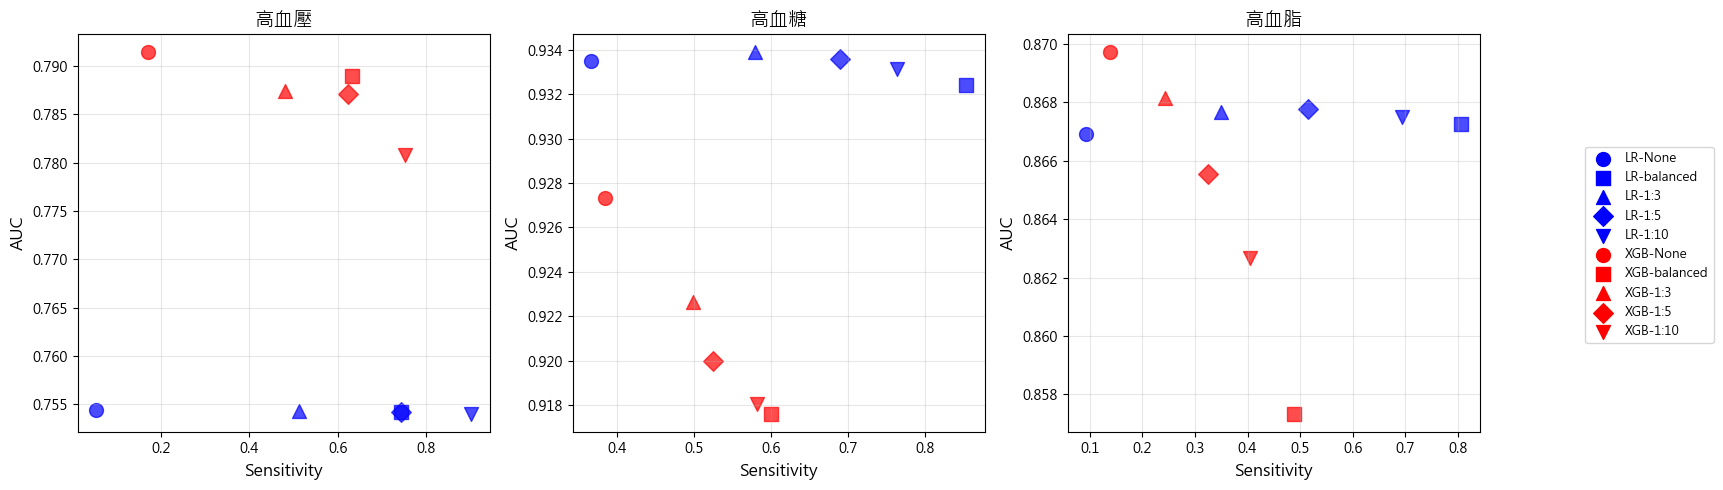


✅ 已儲存: docs/experiments/class_weight_auc_sensitivity.png


In [18]:
# 視覺化：AUC vs Sensitivity trade-off
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

diseases = ['高血壓', '高血糖', '高血脂']
colors = {'LR': 'blue', 'XGB': 'red'}
markers = {'None': 'o', 'balanced': 's', '1:3': '^', '1:5': 'D', '1:10': 'v'}

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    disease_data = all_results[all_results['疾病'] == disease]
    
    for model in ['LR', 'XGB']:
        model_data = disease_data[disease_data['模型'] == model]
        for _, row in model_data.iterrows():
            ax.scatter(row['Sensitivity'], row['AUC'], 
                      c=colors[model], marker=markers[row['權重設定']],
                      s=100, alpha=0.7,
                      label=f"{model}-{row['權重設定']}" if idx == 0 else "")
    
    ax.set_xlabel('Sensitivity', fontsize=12)
    ax.set_ylabel('AUC', fontsize=12)
    ax.set_title(f'{disease}', fontsize=14)
    ax.grid(True, alpha=0.3)

# 建立圖例
handles = []
labels = []
for model, color in colors.items():
    for weight, marker in markers.items():
        handles.append(plt.scatter([], [], c=color, marker=marker, s=100))
        labels.append(f"{model}-{weight}")

fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize=9)
plt.tight_layout()
plt.savefig('../../docs/experiments/class_weight_auc_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ 已儲存: docs/experiments/class_weight_auc_sensitivity.png")

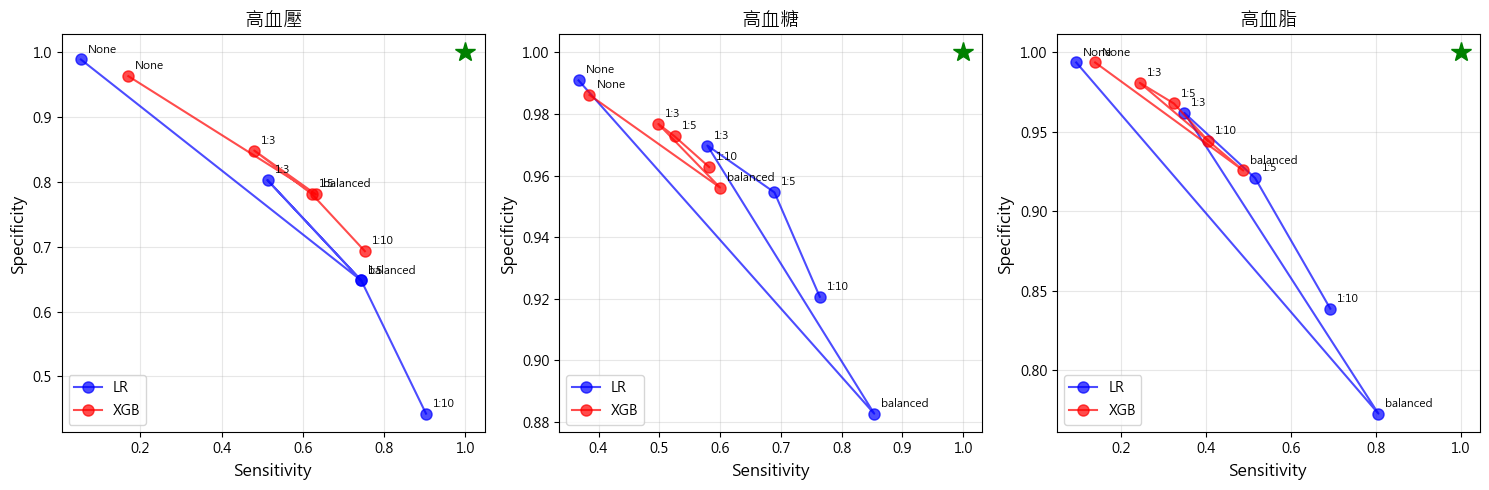


✅ 已儲存: docs/experiments/class_weight_sens_spec_tradeoff.png


In [19]:
# 視覺化：Sensitivity vs Specificity trade-off
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    disease_data = all_results[all_results['疾病'] == disease]
    
    for model in ['LR', 'XGB']:
        model_data = disease_data[disease_data['模型'] == model]
        sensitivities = model_data['Sensitivity'].values
        specificities = model_data['Specificity'].values
        weights = model_data['權重設定'].values
        
        ax.plot(sensitivities, specificities, 'o-', color=colors[model], 
                label=model, alpha=0.7, markersize=8)
        
        # 標註權重設定
        for i, w in enumerate(weights):
            ax.annotate(w, (sensitivities[i], specificities[i]), 
                       textcoords="offset points", xytext=(5, 5), fontsize=8)
    
    ax.set_xlabel('Sensitivity', fontsize=12)
    ax.set_ylabel('Specificity', fontsize=12)
    ax.set_title(f'{disease}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 標記理想點 (1, 1)
    ax.plot(1, 1, 'g*', markersize=15, label='Ideal')

plt.tight_layout()
plt.savefig('../../docs/experiments/class_weight_sens_spec_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ 已儲存: docs/experiments/class_weight_sens_spec_tradeoff.png")

In [20]:
# 最佳權重設定推薦
print("="*80)
print("最佳權重設定推薦")
print("="*80)

print("\n【以 AUC 為主要指標】")
for disease in diseases:
    disease_data = all_results[all_results['疾病'] == disease]
    best_row = disease_data.loc[disease_data['AUC'].idxmax()]
    print(f"{disease}: {best_row['模型']} + {best_row['權重設定']} (AUC={best_row['AUC']:.3f})")

print("\n【以 Sensitivity 為主要指標（適合疾病篩檢）】")
for disease in diseases:
    disease_data = all_results[all_results['疾病'] == disease]
    # 在 AUC > 0.7 的條件下選最高 Sensitivity
    filtered = disease_data[disease_data['AUC'] > 0.7]
    if len(filtered) > 0:
        best_row = filtered.loc[filtered['Sensitivity'].idxmax()]
        print(f"{disease}: {best_row['模型']} + {best_row['權重設定']} (Sens={best_row['Sensitivity']:.3f}, AUC={best_row['AUC']:.3f})")

print("\n【以 Balanced Accuracy 為主要指標】")
for disease in diseases:
    disease_data = all_results[all_results['疾病'] == disease]
    best_row = disease_data.loc[disease_data['Balanced_Acc'].idxmax()]
    print(f"{disease}: {best_row['模型']} + {best_row['權重設定']} (Bal_Acc={best_row['Balanced_Acc']:.3f})")

最佳權重設定推薦

【以 AUC 為主要指標】
高血壓: XGB + None (AUC=0.791)
高血糖: LR + 1:3 (AUC=0.934)
高血脂: XGB + None (AUC=0.870)

【以 Sensitivity 為主要指標（適合疾病篩檢）】
高血壓: LR + 1:10 (Sens=0.903, AUC=0.754)
高血糖: LR + balanced (Sens=0.854, AUC=0.932)
高血脂: LR + balanced (Sens=0.806, AUC=0.867)

【以 Balanced Accuracy 為主要指標】
高血壓: XGB + 1:10 (Bal_Acc=0.723)
高血糖: LR + balanced (Bal_Acc=0.868)
高血脂: LR + balanced (Bal_Acc=0.789)


In [21]:
# 儲存完整結果
all_results.to_csv('../../results/class_weight_ablation_results.csv', index=False)
print("✅ 已儲存: results/class_weight_ablation_results.csv")

# 顯示完整結果表
print("\n" + "="*100)
print("完整實驗結果")
print("="*100)

display_cols = ['疾病', '模型', '權重設定', 'AUC', 'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']
print(all_results[display_cols].round(3).to_string(index=False))

✅ 已儲存: results/class_weight_ablation_results.csv

完整實驗結果
 疾病  模型     權重設定   AUC  Sensitivity  Specificity    F1  Balanced_Acc
高血壓  LR     None 0.754        0.053        0.989 0.096         0.521
高血壓  LR balanced 0.754        0.744        0.648 0.425         0.696
高血壓  LR      1:3 0.754        0.513        0.803 0.411         0.658
高血壓  LR      1:5 0.754        0.744        0.648 0.425         0.696
高血壓  LR     1:10 0.754        0.903        0.443 0.385         0.673
高血糖  LR     None 0.933        0.367        0.991 0.482         0.679
高血糖  LR balanced 0.932        0.854        0.883 0.443         0.868
高血糖  LR      1:3 0.934        0.579        0.970 0.553         0.774
高血糖  LR      1:5 0.934        0.690        0.955 0.559         0.822
高血糖  LR     1:10 0.933        0.764        0.921 0.490         0.842
高血脂  LR     None 0.867        0.094        0.994 0.153         0.544
高血脂  LR balanced 0.867        0.806        0.773 0.299         0.789
高血脂  LR      1:3 0.868        0.349        0.9

In [22]:
# 結論
print("="*80)
print("Class Weight 消融實驗結論")
print("="*80)

print("""
1. AUC 影響
   - class_weight 對 AUC 影響很小（通常 < 1%）
   - AUC 主要反映模型的排序能力，與閾值無關

2. Sensitivity vs Specificity Trade-off
   - 增加正類權重 → Sensitivity ↑, Specificity ↓
   - balanced 權重提供合理的平衡點
   - 過高的權重（如 1:10）可能導致過多的 False Positive

3. 建議設定
   - 一般情況：使用 'balanced' 權重
   - 疾病篩檢（重視 Sensitivity）：使用 1:3 或 1:5
   - 精確診斷（重視 Specificity）：使用 None 或較低權重

4. 與不平衡程度的關係
   - 高血壓（16.7%）：class_weight 效果較小
   - 高血糖/高血脂（~6%）：class_weight 效果較明顯
""")

Class Weight 消融實驗結論

1. AUC 影響
   - class_weight 對 AUC 影響很小（通常 < 1%）
   - AUC 主要反映模型的排序能力，與閾值無關

2. Sensitivity vs Specificity Trade-off
   - 增加正類權重 → Sensitivity ↑, Specificity ↓
   - balanced 權重提供合理的平衡點
   - 過高的權重（如 1:10）可能導致過多的 False Positive

3. 建議設定
   - 一般情況：使用 'balanced' 權重
   - 疾病篩檢（重視 Sensitivity）：使用 1:3 或 1:5
   - 精確診斷（重視 Specificity）：使用 None 或較低權重

4. 與不平衡程度的關係
   - 高血壓（16.7%）：class_weight 效果較小
   - 高血糖/高血脂（~6%）：class_weight 效果較明顯

